# E-Commerce - Data Analysis

In [59]:
import pandas as pd
import sqlite3
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
# import data
customer = pd.read_csv(r"C:\Users\Romai\OneDrive\Documents\Free2move\test\data\customer.csv")
items = pd.read_csv(r"C:\Users\Romai\OneDrive\Documents\Free2move\test\data\items.csv")
orders = pd.read_csv(r"C:\Users\Romai\OneDrive\Documents\Free2move\test\data\orders.csv")
products = pd.read_csv(r"C:\Users\Romai\OneDrive\Documents\Free2move\test\data\products.csv")

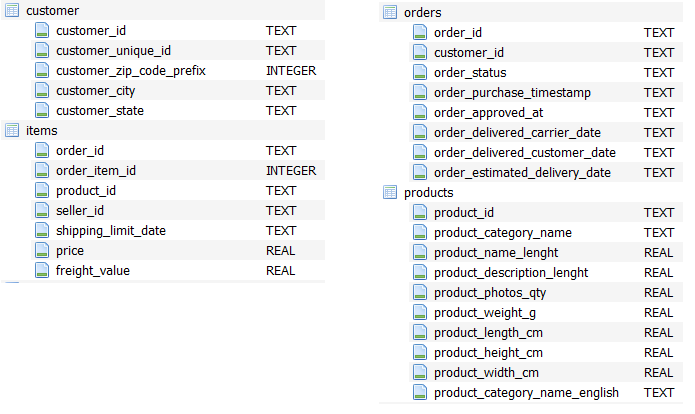

In [61]:
# order_status
orders.groupby(['order_status']).size()

order_status
2018-02-12 11:28:47        1
approved                   2
canceled                 625
created                    5
delivered              96477
invoiced                 314
processing               301
shipped                 1107
unavailable              609
dtype: int64

### Data cleansing

In [62]:
# customer_id duplicates 

print('nb of unique id: ' + str(customer['customer_id'].nunique()))
print('customer dataframe size: ' + str(len(customer)))

counts = customer['customer_id'].value_counts()
customer[customer['customer_id'].isin(counts.index[counts > 1])]

nb of unique id: 99441
customer dataframe size: 99443


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
18,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416.0,sao paulo,SP
19,9b8ce803689b3562defaad4613ef426f,7f3a72e8f988c6e735ba118d54f47458,5416.0,NaN,SP
439,7d1dd3c96c21c803f7a1a32aa8d9feb9,729e9d3fa93475add3ea25424e83e1ad,2559.0,sao paulo,SP
440,7d1dd3c96c21c803f7a1a32aa8d9feb9,NaN,NaN,NaN,SP


In [63]:
# remove duplicates
customer = customer.drop([19,440], axis=0).reset_index(drop=True)

In [64]:
#  two rows with outlier dates ('0000','2077')
orders['order_purchase_timestamp'].astype(str).str[0:4].unique()

array(['2017', '2018', '0000', '2016', '2077'], dtype=object)

In [65]:
orders[~orders['order_purchase_timestamp'].astype(str).str[0:4].isin(['2016','2017','2018'])] 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
130,01855f880aae9a984c7c33b26fcf2e02,2e068340b3037f667ce3224bd59260af,delivered,0000-10-19 15:08:48,0000-10-19 15:35:35,0000-10-23 13:14:16,0000-10-24 15:57:46,0000-10-31 00:00:00
72442,e6a09c11fa9d7a43d90955406cab553c,ef2415ea1854ac041c3700df551dd63e,delivered,2077-08-15 07:55:36,2077-08-15 08:05:24,2077-08-17 15:31:03,2077-08-23 18:10:27,2077-09-04 00:00:00


In [66]:
# delete the two rows, because all dates are outliers
# I checked for the other dates and the outliers are on the same rows
orders = orders.drop([130,72442], axis=0).reset_index(drop=True)

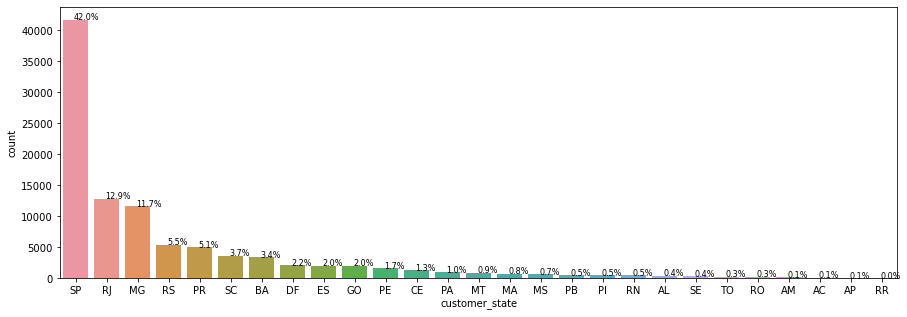

In [67]:
# customer_state

def graph(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 8)
    plt.show()

plot_order = customer.groupby(['customer_state']).size().sort_values(ascending=False).index.values
plt.figure(figsize = (15,5))
ax = sns.countplot(x='customer_state', data=customer,order=plot_order)
plt.xticks(size=10)
plt.xlabel('customer_state', size=10)
plt.yticks(size=10)
plt.ylabel('count',size=10)

graph(ax,customer.customer_state)

The database contains brazilian customers<br/>
TOP 3 states : São Paulo (42%), Rio de Janeiro (12,9%) and Minas Gerais (11,7%) | 2/3 of customers<br/>

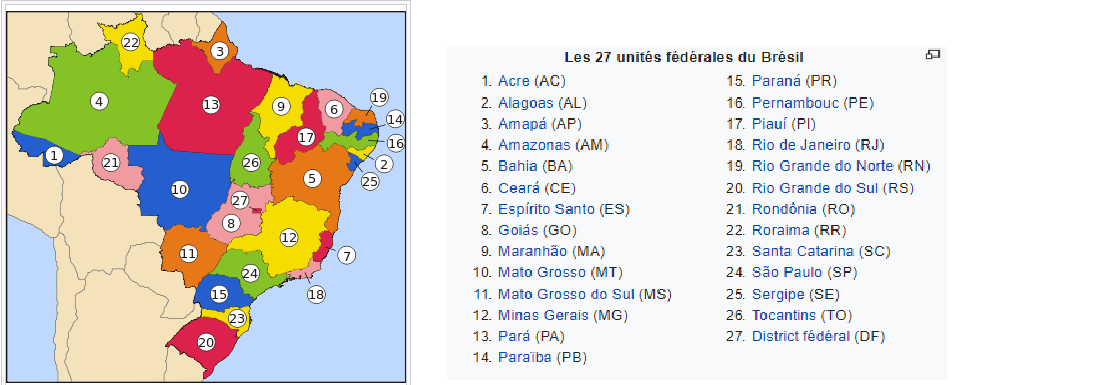

## I. Construct an SQLite database

### 1. Create and insert data in an SQLite database.

In [68]:
# database creation 
conn = sqlite3.connect('database.db')

In [69]:
customer.to_sql('customer',conn)
items.to_sql('items',conn)
orders.to_sql('orders',conn)
products.to_sql('products',conn)

### 2. Create a customer vision that centralizes sales by customers and identify top customers.

In [70]:
# Top customers by number of orders (only 'delivered', 'invoiced' and 'shipped' orders) : 


query1 = ''' 
SELECT 
customer_unique_id,
COUNT(order_id) AS nb_orders
FROM orders o 
LEFT JOIN customer c ON c.customer_id=o.customer_id
WHERE order_status in ('delivered','invoiced','shipped')
GROUP BY 1 
ORDER BY 2 DESC
'''

pd.read_sql(query1,conn)

# TOP 50
# pd.read_sql(query1,conn).head(50) 

# display all rows 
#from IPython.display import display
#result1 = pd.read_sql(query1,conn)
#pd.options.display.max_columns = None
#display(result1)*/ 

,customer_unique_id,nb_orders
0,8d50f5eadf50201ccdcedfb9e2ac8455,16
1,3e43e6105506432c953e165fb2acf44c,9
2,ca77025e7201e3b30c44b472ff346268,7
3,6469f99c1f9dfae7733b25662e7f1782,7
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...,...
94690,0004aac84e0df4da2b147fca70cf8255,1
94691,0000f6ccb0745a6a4b88665a16c9f078,1
94692,0000f46a3911fa3c0805444483337064,1
94693,0000b849f77a49e4a4ce2b2a4ca5be3f,1


In [71]:
# Top customers by total amount spent (only 'delivered', 'invoiced' and 'shipped' orders).
# total_amount_spent = price + freight_value |  average_basket = (total_amount_spent / nb_orders)

query2 = ''' 
SELECT 
customer_unique_id,
SUM(price + freight_value) AS total_amoumt_spent,
COUNT(*) AS nb_items,
COUNT(distinct i.order_id) AS nb_orders,
ROUND(SUM(price + freight_value)/ COUNT(distinct i.order_id),2) AS average_basket
FROM items i 
LEFT JOIN orders o ON o.order_id=i.order_id
LEFT JOIN customer c ON c.customer_id=o.customer_id
WHERE order_status in ('delivered','invoiced','shipped')
GROUP BY 1 
ORDER BY 2 DESC '''

pd.read_sql(query2,conn)


,customer_unique_id,total_amoumt_spent,nb_items,nb_orders,average_basket
0,0a0a92112bd4c708ca5fde585afaa872,13664.08,8,1,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,7571.63,2,2,3785.82
2,763c8b1c9c68a0229c42c9fc6f662b93,7274.88,4,1,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,6929.31,1,1,6929.31
4,459bef486812aa25204be022145caa62,6922.21,1,1,6922.21
...,...,...,...,...,...
94687,6f5b9d1cdccc4d28f0483a612edecacf,11.63,1,1,11.63
94688,2878e5b88167faab17d4fb83a986d38b,11.63,1,1,11.63
94689,b33336f46234b24a613ad9064d13106d,10.89,1,1,10.89
94690,bd06ce0e06ad77a7f681f1a4960a3cc6,10.07,1,1,10.07


### 3. How many customers are repeaters ?

In [72]:
# More than one order <=> repeat customer

query3 = ''' 
SELECT 
COUNT(*) AS nb_repeat_customers
FROM (
SELECT 
customer_unique_id,
COUNT(order_id) AS nb_orders
FROM orders o 
LEFT JOIN customer c ON c.customer_id=o.customer_id
WHERE order_status in ('delivered','invoiced','shipped')
GROUP BY 1 
HAVING nb_orders > 1) AS tb '''

pd.read_sql(query3,conn)

,nb_repeat_customers
0,2875


## II. Sales

### 1. What is the average basket by product category ?

In [73]:
query4 = ''' 
SELECT 
product_category_name,
ROUND(AVG(price + freight_value),2) AS average_basket
FROM items i 
LEFT JOIN products p ON p.product_id=i.product_id
GROUP BY 1 
ORDER BY 1 '''

pd.read_sql(query4,conn)

,product_category_name,average_basket
0,None,131.32
1,agro_industry_and_commerce,369.69
2,air_conditioning,207.99
3,art,135.16
4,arts_and_craftmanship,91.01
...,...,...
67,stationery,110.35
68,tablets_printing_image,105.48
69,telephony,86.88
70,toys,136.35


### 2. What are the most popular products ?

In [74]:
query5 = ''' 
SELECT 
product_category_name,
COUNT(*) AS nb_items
FROM items i 
LEFT JOIN products p ON p.product_id=i.product_id
GROUP BY 1 
ORDER BY 2 DESC '''

pd.read_sql(query5,conn)

,product_category_name,nb_items
0,bed_bath_table,11115
1,health_beauty,9670
2,sports_leisure,8641
3,furniture_decor,8334
4,computers_accessories,7827
...,...,...
67,arts_and_craftmanship,24
68,la_cuisine,14
69,cds_dvds_musicals,14
70,fashion_childrens_clothes,8


### 3. What are repeat customers mostly buying ?

In [75]:
query6 = ''' 
with repeat_customers AS (
SELECT 
customer_unique_id,
COUNT(order_id) AS nb_orders
FROM orders o 
LEFT JOIN customer c ON c.customer_id=o.customer_id
WHERE order_status in ('delivered','invoiced','shipped')
GROUP BY 1 
HAVING nb_orders > 1)

SELECT 
product_category_name,
COUNT(*) AS nb_items
FROM items i 
LEFT JOIN products p ON p.product_id=i.product_id
LEFT JOIN orders o ON o.order_id = i.order_id
LEFT JOIN customer c ON c.customer_id=o.customer_id
INNER JOIN repeat_customers rc ON rc.customer_unique_id=c.customer_unique_id
WHERE order_status in ('delivered','invoiced','shipped') 
GROUP BY 1 
ORDER BY 2 DESC'''

pd.read_sql(query6,conn)

# TOP 10
# pd.read_sql(query6,conn).head(10) 

,product_category_name,nb_items
0,bed_bath_table,1096
1,furniture_decor,809
2,sports_leisure,672
3,health_beauty,552
4,computers_accessories,546
...,...,...
64,home_comfort_2,2
65,fashion_sport,2
66,small_appliances_home_oven_and_coffee,1
67,party_supplies,1


## III. Customer segmentation

### RFM Score Calculations

RECENCY (R): Days since last purchase<br/>
FREQUENCY (F): Total number of purchase<br/>
MONETARY VALUE (M): Total money this customer spent<br/>
<br/>
Sources :<br/>
https://guillaume-martin.github.io/rfm-segmentation-with-python.html<br/>
https://towardsdatascience.com/know-your-customers-with-rfm-9f88f09433bc


In [76]:
#Recency 
# we will use order_purchase_timestamp
from datetime import timedelta
orders['order_purchase_timestamp'] =  pd.to_datetime(orders['order_purchase_timestamp'], format='%Y%m%d %H:%M:%S')
max_date = orders['order_purchase_timestamp'].max().date()
max_date # to define recency

datetime.date(2018, 10, 17)

In [77]:
orders.groupby(orders['order_purchase_timestamp'].dt.year).size()

order_purchase_timestamp
2016      329
2017    45099
2018    54011
dtype: int64

### Calculate the Recency, Frequency and Monetary Value of each customers<br/>
RFM over the last year (last 365 days : Between 2017-10-17 and 2018-10-17).

In [106]:
# RFM 
query7 = ''' 
WITH parameter AS (SELECT date(MAX(order_purchase_timestamp)) AS max_date FROM orders)

SELECT 
customer_unique_id,
ROUND(julianday(max_date) - julianday(date(MAX(order_purchase_timestamp))),2) AS recency,
COUNT(distinct i.order_id) AS frequency,
SUM(price + freight_value) AS monetary
FROM items i 
LEFT JOIN orders o ON o.order_id=i.order_id
LEFT JOIN customer c ON c.customer_id=o.customer_id
CROSS JOIN parameter
WHERE order_status in ('delivered','invoiced','shipped')
AND date(order_purchase_timestamp) >= date(max_date, '-365 days')
AND customer_unique_id is not null
GROUP BY 1
'''

rfm_df = pd.read_sql(query7,conn)
rfm_df['recency']= rfm_df['recency'].astype(int)
rfm_df

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0004aac84e0df4da2b147fca70cf8255,337,1,196.89
3,0004bd2a26a76fe21f786e4fbd80607f,195,1,166.98
4,00050ab1314c0e55a6ca13cf7181fecf,180,1,35.38
...,...,...,...,...
66912,fffb09418989a0dbff854a28163e47c6,304,1,73.16
66913,fffbf87b7a1a6fa8b03f081c5f51a201,294,1,167.32
66914,fffcc512b7dfecaffd80f13614af1d16,189,1,710.70
66915,fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58


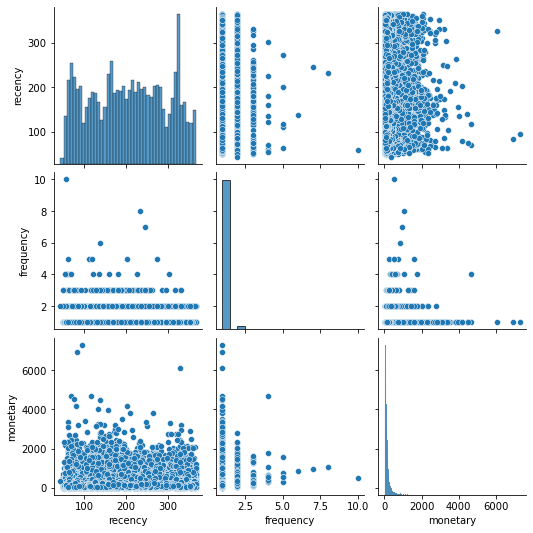

In [107]:
sns.pairplot(rfm_df)

In [108]:
rfm_df.iloc[:,1:4].describe()

,recency,frequency,monetary
count,66917.000000,66917.000000,66917.000000
mean,205.560485,1.025689,163.875213
std,88.978957,0.177860,216.314411
min,44.000000,1.000000,9.590000
25%,129.000000,1.000000,62.980000
50%,207.000000,1.000000,108.260000
75%,280.000000,1.000000,181.620000
max,365.000000,10.000000,7274.880000


### Calculate the R, F and M scores
We will use quintiles. Each quintile contains 20% of the population. 

In [109]:
quintiles = rfm_df[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 113.0, 0.4: 176.0, 0.6: 235.0, 0.8: 301.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 55.18, 0.4: 87.86000000000001, 0.6: 133.416, 0.8: 206.99}}

In [110]:
# Problem: all quintiles are equal to 1 for 'frequency'
rfm_df.groupby(['frequency']).size()

frequency
1     65335
2      1484
3        79
4        10
5         5
6         1
7         1
8         1
10        1
dtype: int64

In [111]:
repeat_customer = (rfm_df[rfm_df['frequency']> 1].shape[0]) / (rfm_df.shape[0])
print(' The number of repeat customers is only ' + "{:.2%}".format(repeat_customer))

 The number of repeat customers is only 2.36%


We assign ranks from 1 to 5.<br/>
A smaller recency value is better whereas higher frequency and monetary values are better.<br/>
For frequency, I don't use quantiles, I reward repeat customers :<br/> 
* F=1 => Score=1
* F=2 => Score=3
* F>2 => Score=5

In [112]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1
    
    
def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 3
    else:
        return 5
    
    

def m_score(x):
    if x <= quintiles['monetary'][.2]:
        return 1
    elif x <= quintiles['monetary'][.4]:
        return 2
    elif x <= quintiles['monetary'][.6]:
        return 3
    elif x <= quintiles['monetary'][.8]:
        return 4
    else:
        return 5
    


In [113]:
rfm_df['R'] = rfm_df['recency'].apply(lambda x: r_score(x))
rfm_df['F'] = rfm_df['frequency'].apply(lambda x: f_score(x))
rfm_df['M'] = rfm_df['monetary'].apply(lambda x: m_score(x))

In [114]:
rfm_df['RFM_Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4,1,1,411
2,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,1,1,4,114
3,0004bd2a26a76fe21f786e4fbd80607f,195,1,166.98,3,1,4,314
4,00050ab1314c0e55a6ca13cf7181fecf,180,1,35.38,3,1,1,311


### Segments based on the R and F scores
* Champions: Bought recently, buy often and spend the most.<br/>
* Loyal Customers: Buy on a regular basis. Responsive to promotions.<br/>
* Potential Loyalist: Recent customers with average frequency.<br/>
* New/recent Customers: Bought most recently, but not often.<br/>
* Promising	Recent: shoppers, but haven’t spent much.<br/>
* Customers Needing Attention: Above average recency, frequency and monetary values. May not have bought very recently though.<br/>
* About To Sleep: Below average recency and frequency. Will lose them if not reactivated.<br/>
* At Risk: Purchased often but a long time ago. Need to bring them back!<br/>
* Can’t Lose Them: Used to purchase frequently but haven’t returned for a long time.<br/>
* Hibernating: Last purchase was long back and low number of orders. May be lost.<br/>
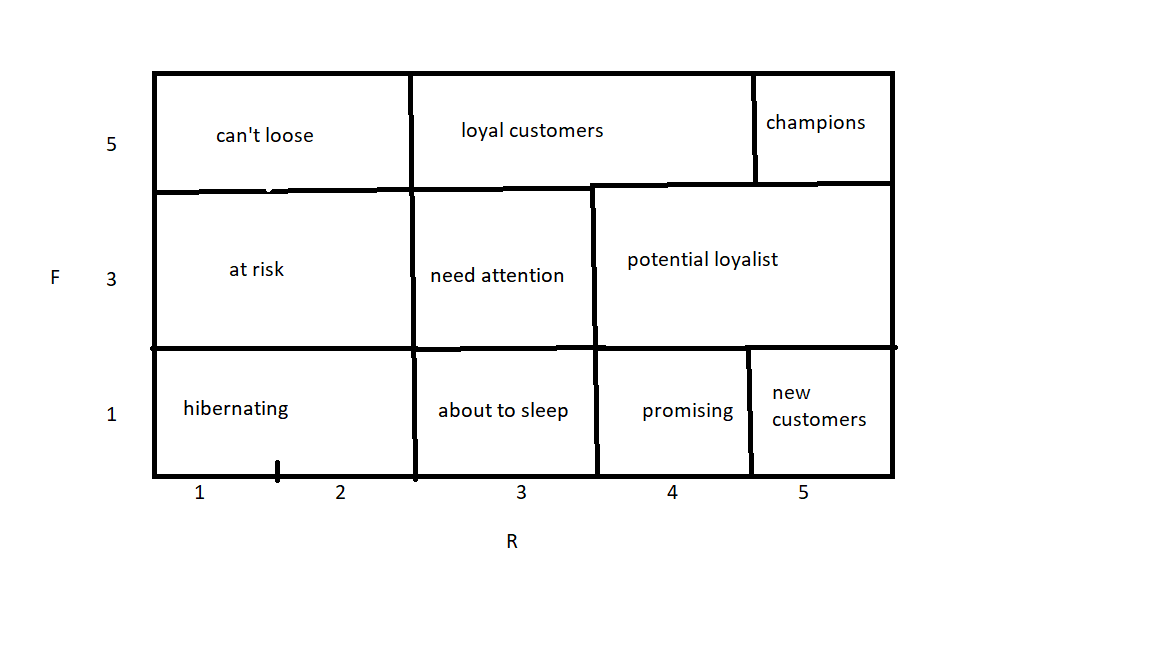

In [115]:
segt_map = {
    r'[1-2]1': 'hibernating',
    r'[1-2]3': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'31': 'about to sleep',
    r'33': 'need attention',
    r'[3-4]5': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5]3': 'potential loyalists',
    r'55': 'champions'
}

rfm_df['Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(segt_map, regex=True)



# Calculate RFM_Score
rfm_df['RFM_Score'] = rfm_df[['R','F','M']].sum(axis=1)

# Create some human friendly labels for the scores
rfm_df['Score'] = 'Green'
rfm_df.loc[rfm_df['RFM_Score']>6,'Score'] = 'Bronze' 
rfm_df.loc[rfm_df['RFM_Score']>9,'Score'] = 'Silver' 
rfm_df.loc[rfm_df['RFM_Score']>11,'Score'] = 'Gold' 
rfm_df.loc[rfm_df['RFM_Score']>13,'Score'] = 'Platinum'


rfm_df.sort_values('RFM_Score', ascending=False)

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Segment,Segment,RFM_Score,Score
13794,34b0cd95480e55c2a701293a2b9671b3,50,3,295.57,5,5,5,555,champions,15,Platinum
30106,7305430719d715992b00be82af4a6aa8,62,3,212.04,5,5,5,555,champions,15,Platinum
52205,c7c19110042036e6266adc998cbf1289,74,3,515.55,5,5,5,555,champions,15,Platinum
46869,b2e9a05d23ea17713b5d7799f2004f8e,80,3,782.64,5,5,5,555,champions,15,Platinum
55684,d4a5e9f19897de65433c9d97bf4b9f8e,92,3,636.90,5,5,5,555,champions,15,Platinum
...,...,...,...,...,...,...,...,...,...,...,...
19724,4b8c35f7dff82de048f8bcb3faceeeea,318,1,52.37,1,1,1,111,hibernating,3,Green
33440,7fc72f80d976775bd31e1c8edf9d8c32,331,1,29.75,1,1,1,111,hibernating,3,Green
18702,4783f02ed6fbca3c4e321d029826dbf1,312,1,29.75,1,1,1,111,hibernating,3,Green
869,034f3cf671ecc03610f2ce339ee72f4b,321,1,39.09,1,1,1,111,hibernating,3,Green


In [116]:
# TOP 10 customers 
rfm_df.sort_values(['RFM_Score', 'monetary'], ascending=[False, False]).head(10)

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Segment,Segment,RFM_Score,Score
52358,c8460e4251689ba205045f3ea17884a1,70,4,4655.88,5,5,5,555,champions,15,Platinum
20809,4facc2e6fbc2bffab2fea92d2b4aa7e4,65,3,1596.96,5,5,5,555,champions,15,Platinum
20416,4e1cce07cd5937c69dacac3c8b13d965,79,3,1294.60,5,5,5,555,champions,15,Platinum
46869,b2e9a05d23ea17713b5d7799f2004f8e,80,3,782.64,5,5,5,555,champions,15,Platinum
14982,394ac4de8f3acb14253c177f0e15bc58,63,5,745.41,5,5,5,555,champions,15,Platinum
55684,d4a5e9f19897de65433c9d97bf4b9f8e,92,3,636.90,5,5,5,555,champions,15,Platinum
57685,dc813062e0fc23409cd255f7f53c7074,55,4,597.99,5,5,5,555,champions,15,Platinum
34065,821e75291b1ad362e614c0ea79fc95a6,86,3,537.44,5,5,5,555,champions,15,Platinum
26263,6469f99c1f9dfae7733b25662e7f1782,111,5,533.98,5,5,5,555,champions,15,Platinum
52205,c7c19110042036e6266adc998cbf1289,74,3,515.55,5,5,5,555,champions,15,Platinum


In [117]:
# Score
reorderlist = [ 'Platinum','Gold','Silver','Bronze','Green']
rfm_df.groupby(['Score']).size().reindex(reorderlist)

Score
Platinum       53
Gold          477
Silver       8285
Bronze      31573
Green       26529
dtype: int64

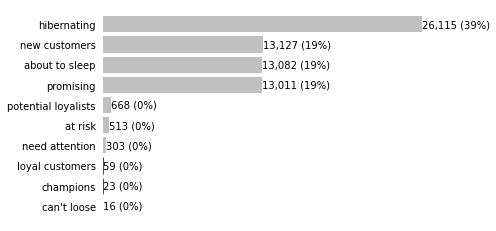

In [118]:
# count the number of customers in each segment
segments_counts = rfm_df['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

#### For each of the segments, you could design appropriate actions, for example:
* Champions: Reward them. They can become evangelists and early adopters of new products.
* Loyal customers: Up-sell higher value products. Engage them. Ask for reviews.
* Potential loyalist: Recommend other products. Engage in loyalty programs.
* Recent/new customers: Provide a good onboarding process. Start building the relationship.
* Promising: Create more brand awareness. Provide free trials.
* Needs attention: Reactivate them. Provide limited time offers. Recommend new products based on purchase history.
* About to sleep: Reactivate them. Share valuable resources. Recommend popular products. Offer discounts.
* At risk: Send personalised email or other messages to reconnect. Provide good offers and share valuable resources.
* Can’t lose them: Win them back. Talk to them. Make them special offers. Make them feel valuable.
* Hibernating: Recreate brand value. Offer relevant products and good offers

## Conclusion

We have very few loyal customers.<br/> 
Over 97% of our customers are non repeat customers.<br/>
We need to make a plan on how to improve retention.

To go further :<br/> 

* Cohort Analysis
* K-means algorithm<br/> 

Tools used : Jupyter Notebook, DB Browser for SQLite and Spyder.  
